# Assignment 4: AutoEncoder

In [1]:
import json
import sys
import shutil
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
import torch
import wandb

PROJECT_DIR = '../..'
sys.path.insert(0, PROJECT_DIR)

from models.AutoEncoders import AutoEncoder, CNNAutoEncoder
from models.knn import KNN
from models.MLP import get_activation, get_loss
from models.pca import PCA
from performance_measures import ClassificationMeasures, MultiLabelClassificationMeasures, \
                                                                                RegressionMeasures

In [2]:
def train_val_test_split(
    X: npt.NDArray, y: npt.NDArray, train_size: float = 0.8, val_size: float = 0.1,
    test_size: float = 0.1, random_seed: int | None = 0
) -> Tuple[npt.NDArray, npt.NDArray, npt.NDArray, npt.NDArray, npt.NDArray, npt.NDArray]:
    """ Partitions dataset represented as a pair of array, into three groups. """

    # Reinitialize the random number generator
    if random_seed is not None:
        np.random.seed(random_seed)

    # Ensure the sizes form a probability simplex
    assert train_size + val_size + test_size == 1.0, \
                                    'train_size, val_size, and test_size sizes must sum to 1.'
    assert 0.0 <= train_size <= 1.0, 'train_size must lie in (0, 1)'
    assert 0.0 <= val_size <= 1.0, 'val_size must lie in (0, 1)'
    assert 0.0 <= test_size <= 1.0, 'test_size must lie in (0, 1)'

    # Ensure that X and y are of same length
    assert X.shape[0] == y.shape[0], 'Expected X and y to be the same length'

    # Shuffle the indices
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    # Shuffle the dataset as per the indices
    X = X[indices]
    y = y[indices]

    # Compute the splitting indices
    train_end = int(train_size * X.shape[0])
    val_end = train_end + int(val_size * X.shape[0])

    # Split the data
    X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
    y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

    return X_train, X_val, X_test, y_train, y_val, y_test

## AutoEncoder: Comparative Analysis

### CNN AutoEncoder

#### Dataset Analysis and Preprocessing

In [3]:
df = pd.read_csv(f'{PROJECT_DIR}/data/external/fashion_mnist/fashion-mnist_train.csv')

X = df.to_numpy()[:, 1:].reshape(-1, 28, 28)
y = df.to_numpy()[:, 0]

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, train_size=0.7, val_size=0.1, test_size=0.2)

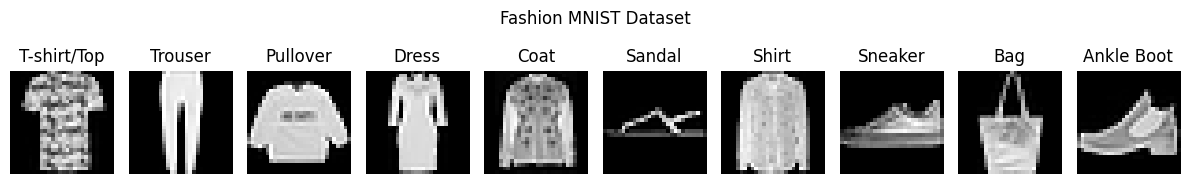

In [4]:
LABEL_MAP = {
    0: 'T-shirt/Top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

fig, axs = plt.subplots(1, 10, figsize=(12, 2))
fig.suptitle('Fashion MNIST Dataset')

for label_idx in range(len(LABEL_MAP)):
    for sample_idx in range(len(X)):
        if y[sample_idx] != label_idx:
            continue
        axs[label_idx].imshow(X[sample_idx], cmap='gray')
        axs[label_idx].set_title(LABEL_MAP[label_idx])
        axs[label_idx].axis('off')
        break

plt.tight_layout()
plt.savefig('figures/fashion_mnist.png', bbox_inches='tight')
plt.show()

In [5]:
class FashionMNISTDataset(torch.utils.data.Dataset):

    def __init__(self, images):
        self.images = images[:, np.newaxis, :, :]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return torch.Tensor(self.images[idx])

In [6]:
train_dataset = FashionMNISTDataset(X_train)
val_dataset = FashionMNISTDataset(X_val)
test_dataset = FashionMNISTDataset(X_test)

#### Hyperparameter Tuning

In [7]:
with open(f'{PROJECT_DIR}/assignments/4/results/k_optimal.txt', 'r', encoding='utf-8') as file:
    k_optimal = int(file.readline().strip())

def train_worker():
    """ Trains a CNNAutoEncoder for a given configuration. """

    wandb.init()
    cnn_autoenc = CNNAutoEncoder(
        latent_dimension=k_optimal,
        activation='relu',
        pool='maxpool',
        dropout=0.2,
        kernel_size=wandb.config.kernel_size,
        lr=wandb.config.lr,
        num_blocks=wandb.config.num_blocks,
        optimizer=wandb.config.optimizer
    )
    cnn_autoenc.fit(train_dataset, val_dataset, wandb_log=True)

In [8]:
# sweep_config = {
#     'name': 'autoencoder-hyperparameter-tuning',
#     'method': 'grid',
#     'metric': { 'name': 'val_loss', 'goal': 'minimize' },
#     'parameters': {
#         'kernel_size': { 'values': [3, 5] },
#         'lr': { 'values': [1e-6, 1e-5] },
#         'num_blocks': { 'values': [2, 3, 4] },
#         'optimizer': { 'values': ['sgd', 'adam'] },
#     }
# }

# sweep_id = wandb.sweep(sweep_config, project='smai-m24-cnn')
# wandb.agent(sweep_id, train_worker)
# wandb.finish()
# shutil.rmtree('wandb')

In [9]:
# sweep_config = {
#     'name': 'autoencoder-hyperparameter-effects-layers',
#     'method': 'grid',
#     'metric': { 'name': 'val_loss', 'goal': 'minimize' },
#     'parameters': {
#         'kernel_size': { 'values': [3] },
#         'lr': { 'values': [1e-6] },
#         'num_blocks': { 'values': [2, 3, 4] },
#         'optimizer': { 'values': ['sgd'] },
#     }
# }

# sweep_id = wandb.sweep(sweep_config, project='smai-m24-cnn')
# wandb.agent(sweep_id, train_worker)
# wandb.finish()
# shutil.rmtree('wandb')

#### Plots and Visualizations

In [10]:
with open(f'{PROJECT_DIR}/assignments/4/results/cnn_autoencoder_hyperparameters.json', \
                                                                'r', encoding='utf-8') as file:
    config = json.load(file)

with open(f'{PROJECT_DIR}/assignments/4/results/k_optimal.txt', 'r', encoding='utf-8') as file:
    k_optimal = int(file.readline().strip())

cnn_autoenc = CNNAutoEncoder(
    latent_dimension=k_optimal,
    activation='relu',
    pool='maxpool',
    dropout=0.2,
    kernel_size=config['kernel_size'],
    lr=config['lr'],
    num_blocks=config['num_blocks'],
    optimizer=config['optimizer']
)
cnn_autoenc.fit(train_dataset, val_dataset, verbose=True)
print()

Epoch 0, Train Loss: 13061.871859827208, Val Loss: 5634.296430871842
Epoch 1, Train Loss: 4554.51706548547, Val Loss: 3081.260050022856
Epoch 2, Train Loss: 3126.30656067034, Val Loss: 2812.4497719622673
Epoch 3, Train Loss: 2677.4280800394495, Val Loss: 2458.5228654577377
Epoch 4, Train Loss: 2427.6323887403014, Val Loss: 2085.0140413324884
Epoch 5, Train Loss: 2261.2506272722, Val Loss: 1936.6146629820478
Epoch 6, Train Loss: 2144.9686580521407, Val Loss: 1846.2838095807015
Epoch 7, Train Loss: 2053.805545060215, Val Loss: 1727.4506524268618
Epoch 8, Train Loss: 1988.431382259883, Val Loss: 1700.0812131191822
Epoch 9, Train Loss: 1947.3449174310085, Val Loss: 1813.7844030501994



Reconstruction error: 1818.5985827605555


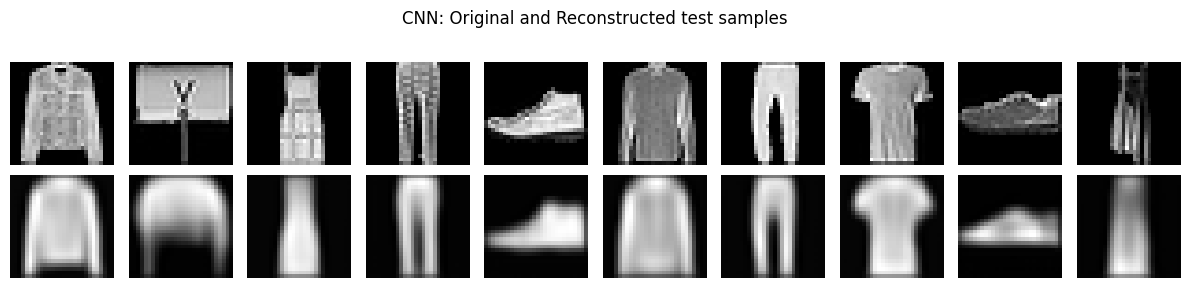

In [26]:
X_test_reconstructed = cnn_autoenc.forward_dataset(test_dataset).numpy().reshape(-1, 28, 28)
error = np.mean((X_test - X_test_reconstructed) ** 2)
print(f'Reconstruction error: {error}')

fig, axs = plt.subplots(2, 10, figsize=(12, 3))
fig.suptitle('CNN: Original and Reconstructed test samples')

for sample_idx in range(10):
    axs[0][sample_idx].imshow(X_test[sample_idx], cmap='gray')
    axs[0][sample_idx].axis('off')
    axs[1][sample_idx].imshow(X_test_reconstructed[sample_idx], cmap='gray')
    axs[1][sample_idx].axis('off')

plt.tight_layout()
plt.savefig('figures/cnn_reconstruction.png', bbox_inches='tight')
plt.show()

In [28]:
print(y_test[:10])

[4 8 3 1 9 6 1 0 7 3]


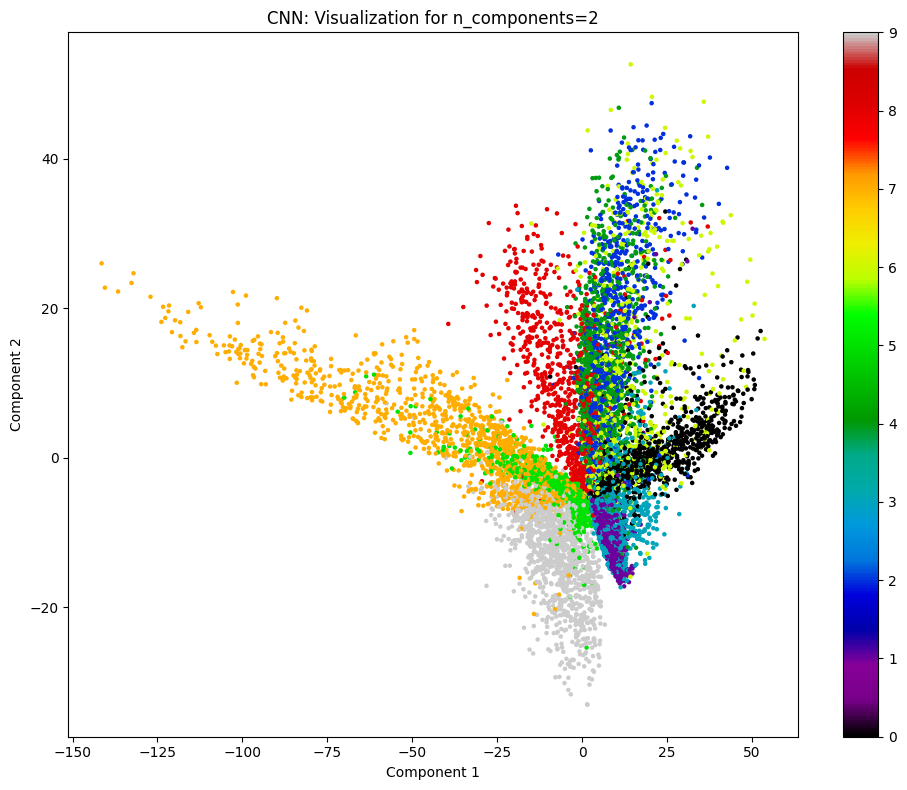

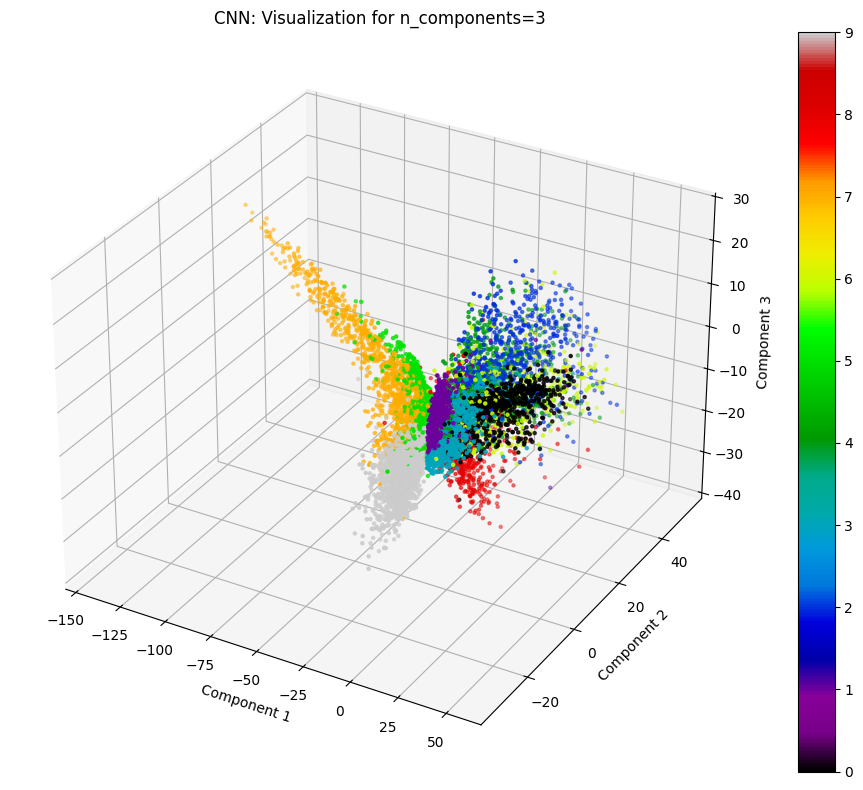

In [27]:
# Compute latent space representation
X_test_encoded = cnn_autoenc.encode_dataset(test_dataset).numpy()

# Compute 2D representation
pca = PCA(n_components=2)
pca.fit(X_test_encoded)
X_test_encoded_2d = pca.transform(X_test_encoded)

# Visualize 2D representation
plt.figure(figsize=(10, 8))
plt.scatter(X_test_encoded_2d[:, 0], X_test_encoded_2d[:, 1], c=y_test, cmap='nipy_spectral', s=5)
plt.title('CNN: Visualization for n_components=2')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.tight_layout()
plt.savefig('figures/cnn_2d_visualization.png', bbox_inches='tight')
plt.show()

# Compute 3D representation
pca = PCA(n_components=3)
pca.fit(X_test_encoded)
X_test_encoded_3d = pca.transform(X_test_encoded)

# Visualize 3D representation
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_test_encoded_3d[:, 0], X_test_encoded_3d[:, 1], X_test_encoded_3d[:, 2], c=y_test, cmap='nipy_spectral', s=5)
ax.set_title('CNN: Visualization for n_components=3')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
fig.colorbar(scatter)
plt.tight_layout()
plt.savefig('figures/cnn_3d_visualization.png', bbox_inches='tight')
plt.show()

### MLP AutoEncoder

In [13]:
with open(f'{PROJECT_DIR}/assignments/4/results/mlp_autoencoder_hyperparameters.json', \
                                                                'r', encoding='utf-8') as file:
    config = json.load(file)

with open(f'{PROJECT_DIR}/assignments/4/results/k_optimal.txt', 'r', encoding='utf-8') as file:
    k_optimal = int(file.readline().strip())

mlp_autoenc = AutoEncoder(
    latent_dimension=k_optimal,
    optimizer='mini-batch',
    batch_size=32,
    activation=get_activation(config['activation']),
    lr=config['lr'],
    num_hidden_layers=config['num_hidden_layers'],
)
mlp_autoenc.fit(X_train.reshape(-1, 784), X_val.reshape(-1, 784), verbose=True)

# wandb.init(project='smai-m24-cnn', name='mlp-autoencoder')
# mlp_autoenc.fit(X_train.reshape(-1, 784), X_val.reshape(-1, 784), verbose=True, wandb_log=True)
# wandb.finish()

Epoch 0, Val Loss: 5705.703506455665
Epoch 1, Val Loss: 5709.5763186997065
Epoch 2, Val Loss: 5715.127954794992
Epoch 3, Val Loss: 5722.840795389349
Epoch 4, Val Loss: 5733.138115765998
Epoch 5, Val Loss: 5746.015064909157
Epoch 6, Val Loss: 5761.299717076164
Epoch 7, Val Loss: 5775.4602782340635
Epoch 8, Val Loss: 5790.456973388194
Epoch 9, Val Loss: 5807.443387614994


Reconstruction error: 5671.708497353421


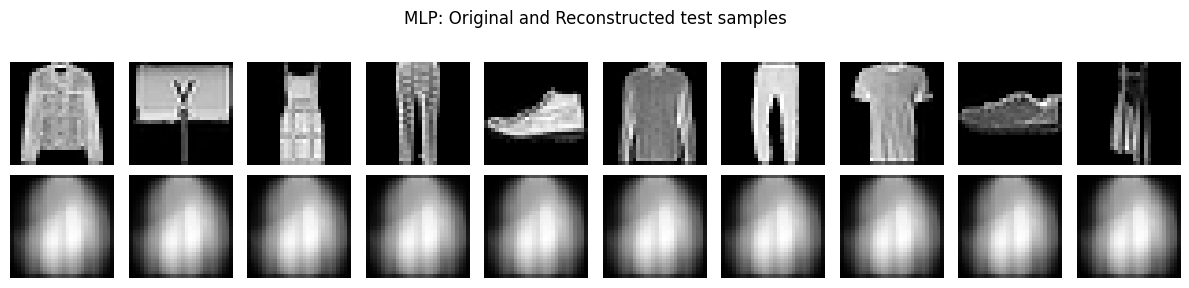

In [14]:
X_test_reconstructed = mlp_autoenc.forward(X_test.reshape(-1, 784)).reshape(-1, 28, 28)
error = np.mean((X_test - X_test_reconstructed) ** 2)
print(f'Reconstruction error: {error}')

fig, axs = plt.subplots(2, 10, figsize=(12, 3))
fig.suptitle('MLP: Original and Reconstructed test samples')

for sample_idx in range(10):
    axs[0][sample_idx].imshow(X_test[sample_idx], cmap='gray')
    axs[0][sample_idx].axis('off')
    axs[1][sample_idx].imshow(X_test_reconstructed[sample_idx], cmap='gray')
    axs[1][sample_idx].axis('off')

plt.tight_layout()
plt.savefig('figures/mlp_reconstruction.png', bbox_inches='tight')
plt.show()

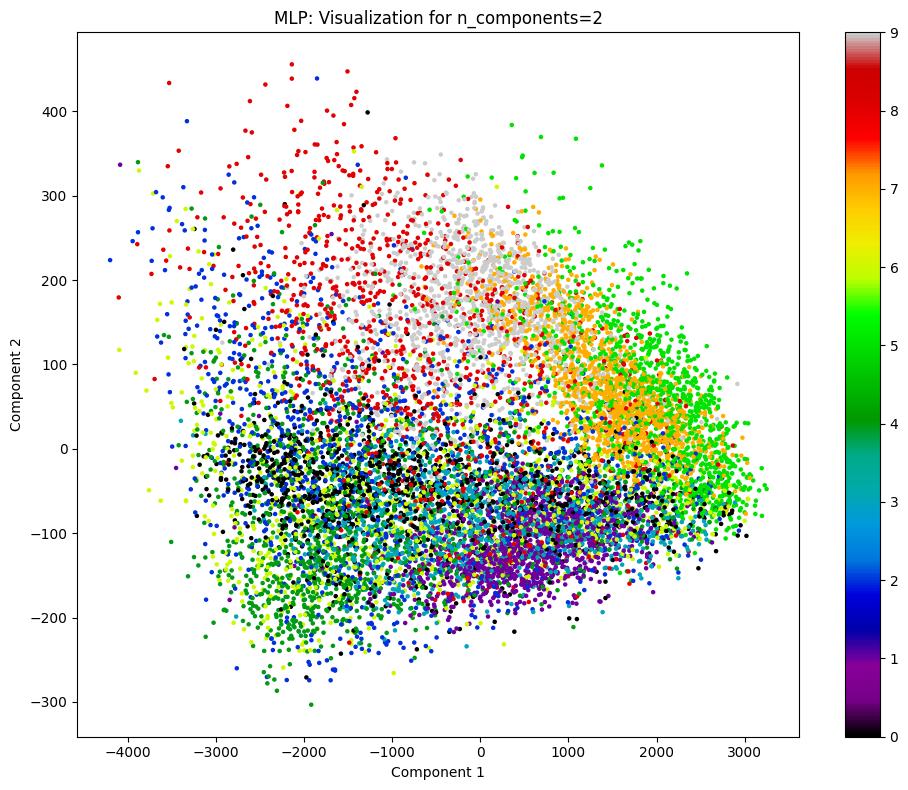

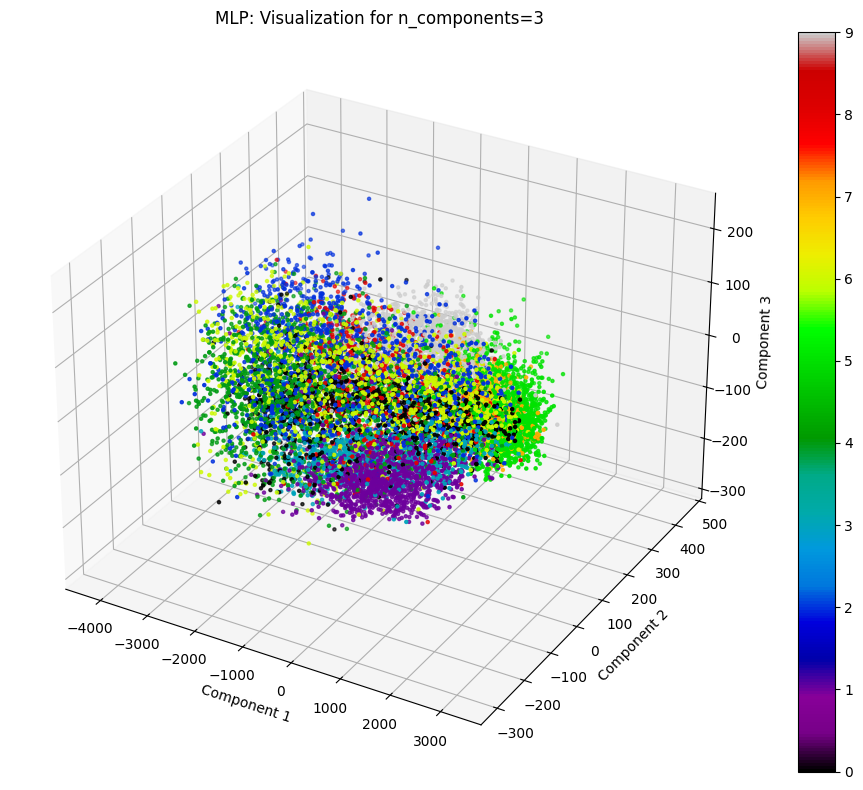

In [24]:
# Compute latent space representation
X_test_encoded = mlp_autoenc.encode(X_test.reshape(-1, 784))

# Compute 2D representation
pca = PCA(n_components=2)
pca.fit(X_test_encoded)
X_test_encoded_2d = pca.transform(X_test_encoded)

# Visualize 2D representation
plt.figure(figsize=(10, 8))
plt.scatter(X_test_encoded_2d[:, 0], X_test_encoded_2d[:, 1], c=y_test, cmap='nipy_spectral', s=5)
plt.title('MLP: Visualization for n_components=2')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.tight_layout()
plt.savefig('figures/mlp_2d_visualization.png', bbox_inches='tight')
plt.show()

# Compute 3D representation
pca = PCA(n_components=3)
pca.fit(X_test_encoded)
X_test_encoded_3d = pca.transform(X_test_encoded)

# Visualize 3D representation
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_test_encoded_3d[:, 0], X_test_encoded_3d[:, 1], X_test_encoded_3d[:, 2], c=y_test, cmap='nipy_spectral', s=5)
ax.set_title('MLP: Visualization for n_components=3')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
fig.colorbar(scatter)
plt.tight_layout()
plt.savefig('figures/mlp_3d_visualization.png', bbox_inches='tight')
plt.show()

### PCA Autoencoder

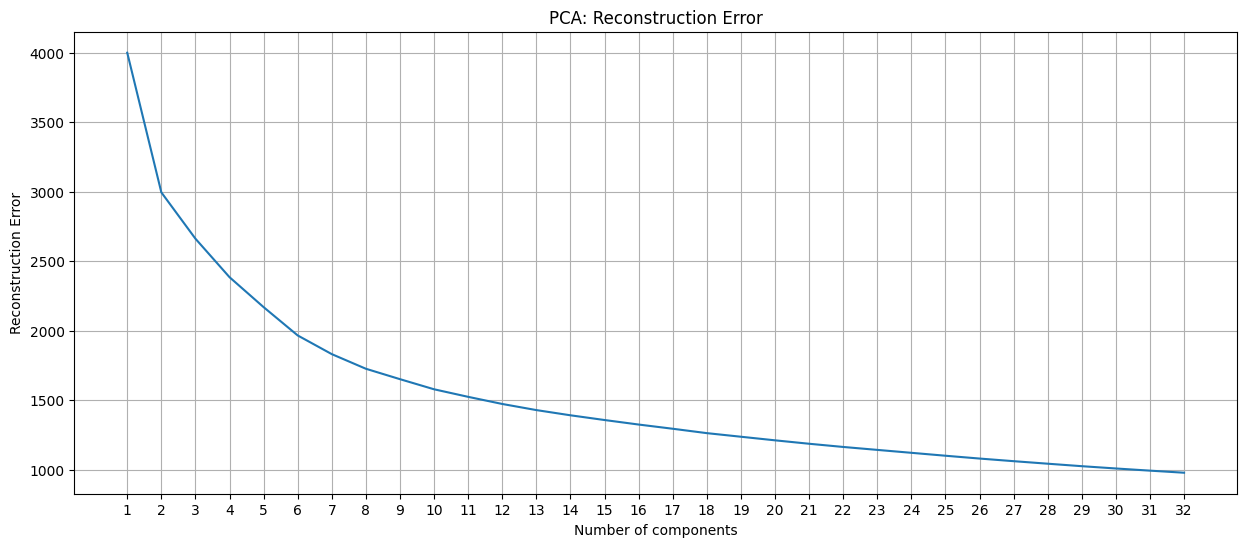

In [15]:
components = range(1, 33)
reconstruction_errors = []

for component in components:
    pca_autoenc = PCA(n_components=component).fit(X_train.reshape(-1, 784))
    X_val_reconstructed = pca_autoenc.forward(X_val.reshape(-1, 784))
    error = np.mean((X_val.reshape(-1, 784) - X_val_reconstructed) ** 2)
    reconstruction_errors.append(error)

plt.figure(figsize=(15,6))
plt.plot(components, reconstruction_errors)
plt.title('PCA: Reconstruction Error')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.xticks(components)
plt.grid()
plt.savefig('figures/pca_reconstruction_error.png', bbox_inches='tight')
plt.show()

Reconstruction error: 1977.5109844216408


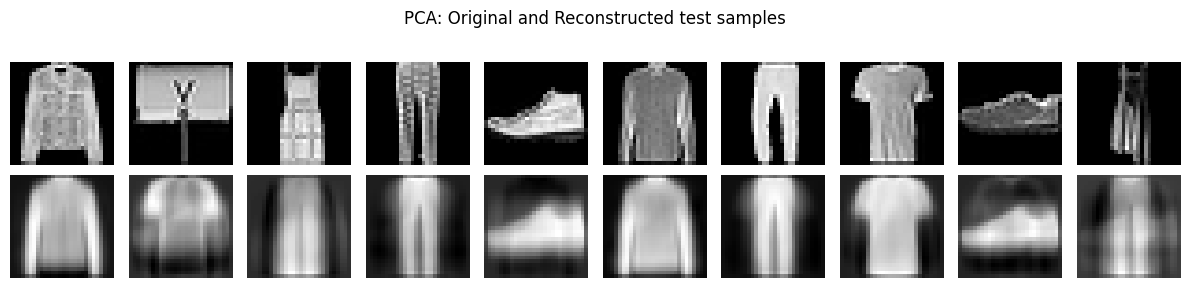

In [16]:
with open(f'{PROJECT_DIR}/assignments/4/results/k_optimal.txt', 'r', encoding='utf-8') as file:
    k_optimal = int(file.readline().strip())

pca_autoenc = PCA(n_components=k_optimal).fit(X_train.reshape(-1, 784))
X_test_reconstructed = pca_autoenc.forward(X_test.reshape(-1, 784)).reshape(-1, 28, 28)
error = np.mean((X_test - X_test_reconstructed) ** 2)
print(f'Reconstruction error: {error}')

fig, axs = plt.subplots(2, 10, figsize=(12, 3))
fig.suptitle('PCA: Original and Reconstructed test samples')

for sample_idx in range(10):
    axs[0][sample_idx].imshow(X_test[sample_idx], cmap='gray')
    axs[0][sample_idx].axis('off')
    axs[1][sample_idx].imshow(X_test_reconstructed[sample_idx], cmap='gray')
    axs[1][sample_idx].axis('off')

plt.tight_layout()
plt.savefig('figures/pca_reconstruction.png', bbox_inches='tight')
plt.show()

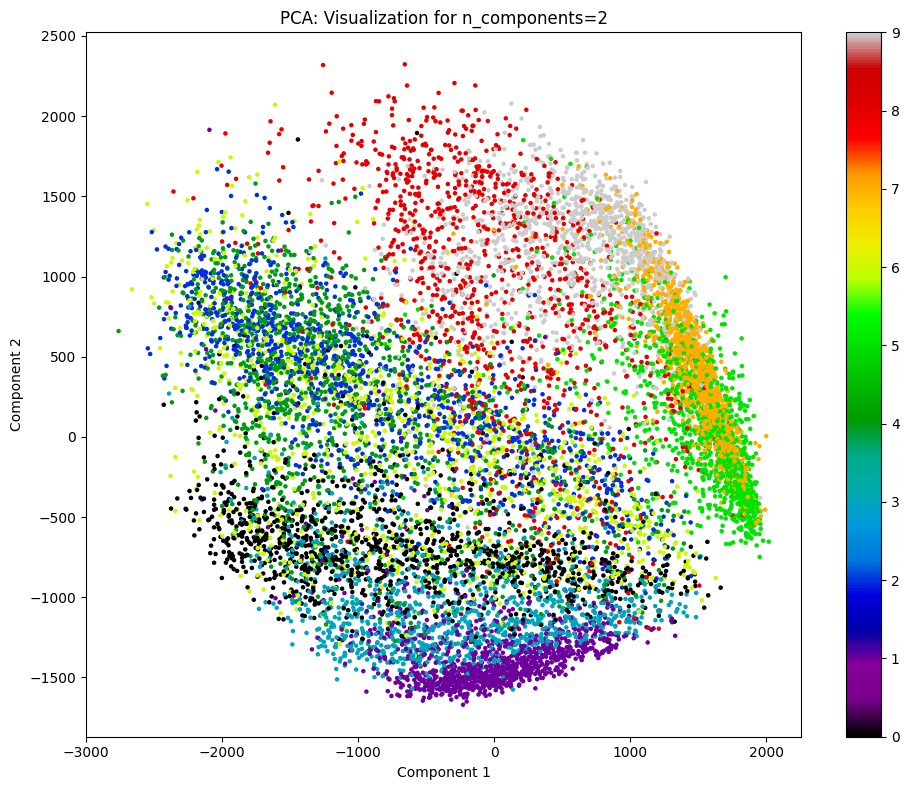

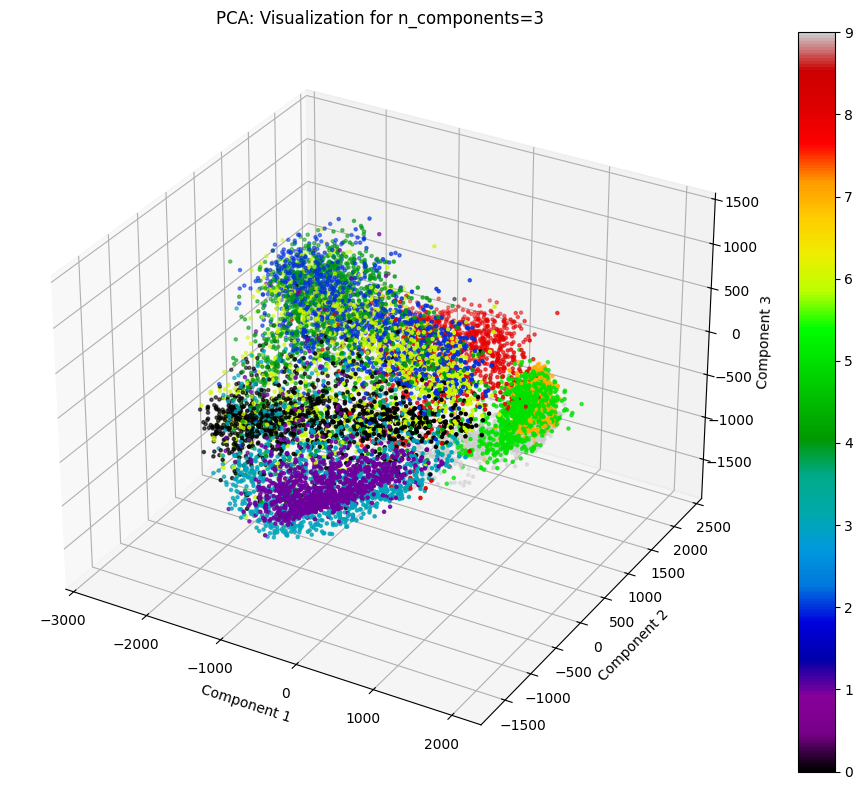

In [25]:
# Compute latent space representation
X_test_encoded = pca_autoenc.encode(X_test.reshape(-1, 784))

# Compute 2D representation
pca = PCA(n_components=2)
pca.fit(X_test_encoded)
X_test_encoded_2d = pca.transform(X_test_encoded)

# Visualize 2D representation
plt.figure(figsize=(10, 8))
plt.scatter(X_test_encoded_2d[:, 0], X_test_encoded_2d[:, 1], c=y_test, cmap='nipy_spectral', s=5)
plt.title('PCA: Visualization for n_components=2')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.tight_layout()
plt.savefig('figures/pca_2d_visualization.png', bbox_inches='tight')
plt.show()

# Compute 3D representation
pca = PCA(n_components=3)
pca.fit(X_test_encoded)
X_test_encoded_3d = pca.transform(X_test_encoded)

# Visualize 3D representation
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_test_encoded_3d[:, 0], X_test_encoded_3d[:, 1], X_test_encoded_3d[:, 2], c=y_test, cmap='nipy_spectral', s=5)
ax.set_title('PCA: Visualization for n_components=3')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
fig.colorbar(scatter)
plt.tight_layout()
plt.savefig('figures/pca_3d_visualization.png', bbox_inches='tight')
plt.show()

### KNN Classification

In [17]:
X_train_cnn = cnn_autoenc.encode_dataset(train_dataset).numpy()
X_test_cnn = cnn_autoenc.encode_dataset(test_dataset).numpy()

X_train_mlp = mlp_autoenc.encode(X_train.reshape(-1, 784))
X_test_mlp = mlp_autoenc.encode(X_test.reshape(-1, 784))

X_train_pca = pca_autoenc.encode(X_train.reshape(-1, 784))
X_test_pca = pca_autoenc.encode(X_test.reshape(-1, 784))

In [18]:
k = 15
metric = 'manhattan'

knn = KNN(k, metric)
knn.fit(X_train_cnn, y_train)
y_train_pred_cnn = knn.predict(X_train_cnn)
y_test_pred_cnn = knn.predict(X_test_cnn)
train_acc_cnn = ClassificationMeasures(y_train, y_train_pred_cnn).accuracy_score()
test_acc_cnn = ClassificationMeasures(y_test, y_test_pred_cnn).accuracy_score()
conf_matrix_cnn = ClassificationMeasures(y_test, y_test_pred_cnn).confusion_matrix()

knn = KNN(k, metric)
knn.fit(X_train_mlp, y_train)
y_train_pred_mlp = knn.predict(X_train_mlp)
y_test_pred_mlp = knn.predict(X_test_mlp)
train_acc_mlp = ClassificationMeasures(y_train, y_train_pred_mlp).accuracy_score()
test_acc_mlp = ClassificationMeasures(y_test, y_test_pred_mlp).accuracy_score()
conf_matrix_mlp = ClassificationMeasures(y_test, y_test_pred_mlp).confusion_matrix()

knn = KNN(k, metric)
knn.fit(X_train_pca, y_train)
y_train_pred_pca = knn.predict(X_train_pca)
y_test_pred_pca = knn.predict(X_test_pca)
train_acc_pca = ClassificationMeasures(y_train, y_train_pred_pca).accuracy_score()
test_acc_pca = ClassificationMeasures(y_test, y_test_pred_pca).accuracy_score()
conf_matrix_pca = ClassificationMeasures(y_test, y_test_pred_pca).confusion_matrix()

In [19]:
print('CNN Autoencoder')
print(f'Train Accuracy: {train_acc_cnn}')
print(f'Test Accuracy: {test_acc_cnn}')
print()

print('MLP Autoencoder')
print(f'Train Accuracy: {train_acc_mlp}')
print(f'Test Accuracy: {test_acc_mlp}')
print()

print('PCA Autoencoder')
print(f'Train Accuracy: {train_acc_pca}')
print(f'Test Accuracy: {test_acc_pca}')

CNN Autoencoder
Train Accuracy: 0.7975952380952381
Test Accuracy: 0.7735833333333333

MLP Autoencoder
Train Accuracy: 0.6592380952380953
Test Accuracy: 0.6193333333333333

PCA Autoencoder
Train Accuracy: 0.7972619047619047
Test Accuracy: 0.7736666666666666


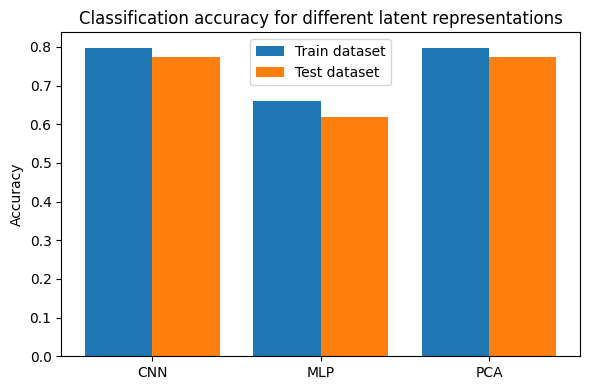

In [20]:
train_acc = [train_acc_cnn, train_acc_mlp, train_acc_pca]
test_acc = [test_acc_cnn, test_acc_mlp, test_acc_pca]

fig, ax = plt.subplots(figsize=(6,4))
bars1 = ax.bar(np.arange(3) - 0.2, train_acc, 0.4, label='Train dataset')
bars2 = ax.bar(np.arange(3) + 0.2, test_acc, 0.4, label='Test dataset')

ax.set_ylabel('Accuracy')
ax.set_title('Classification accuracy for different latent representations')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['CNN', 'MLP', 'PCA'])
ax.legend()

plt.tight_layout()
plt.savefig('figures/knn_accuracy.png', bbox_inches='tight')
plt.show()

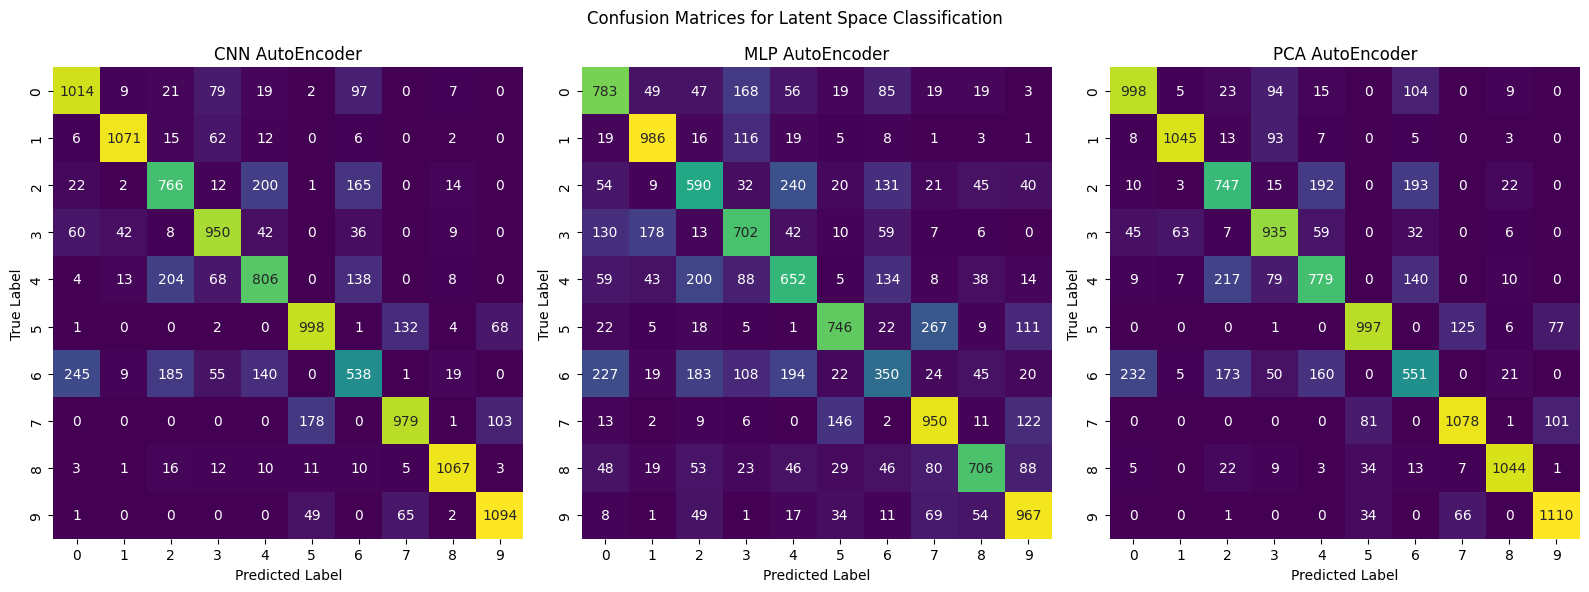

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle('Confusion Matrices for Latent Space Classification')

for idx in range(3):
    axs[idx].set_ylabel('True Label')
    axs[idx].set_xlabel('Predicted Label')

sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="viridis", cbar=False, ax=axs[0])
axs[0].set_title('CNN AutoEncoder')

sns.heatmap(conf_matrix_mlp, annot=True, fmt="d", cmap="viridis", cbar=False, ax=axs[1])
axs[1].set_title('MLP AutoEncoder')

sns.heatmap(conf_matrix_pca, annot=True, fmt="d", cmap="viridis", cbar=False, ax=axs[2])
axs[2].set_title('PCA AutoEncoder')

for idx in range(3):
    axs[idx].set_ylabel('True Label')
    axs[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('figures/knn_confusion_matrix.png', bbox_inches='tight')
plt.show()